In [3]:
!git clone https://github.com/google/deluca.git

fatal: destination path 'deluca' already exists and is not an empty directory.


/Users/rsalik/.pyenv/versions/3.13.1/lib/python3.13/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [4]:
%cd deluca

!pip install -e .

/Users/rsalik/Documents/Code/Google/deluca/deluca
Obtaining file:///Users/rsalik/Documents/Code/Google/deluca/deluca

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
ERROR: file:///Users/rsalik/Documents/Code/Google/deluca/deluca does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


#This cell creates an LDS environment and plots the signal with random activations.

In [2]:
%load_ext autoreload
%autoreload 2

# Imports
# Standard library imports
from typing import Sequence

# Third-party imports
import jax
import jax.numpy as jnp
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from brax.envs.inverted_double_pendulum import InvertedDoublePendulum

# Local imports
from deluca.agents._drc import DRC
from deluca.agents._grc import GRC
from deluca.agents._lqg import LQG
from deluca.agents._random import SimpleRandom
from deluca.agents._sfc import SFC
from deluca.agents._zero import Zero
from deluca.core import Agent, Env, field
from deluca.envs import LDS, SinusDisturbance, Pendulum2D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%load_ext autoreload
%autoreload 2

env = LDS() #LDS with random initiations and dimensions as specified
#env = lds.LDS(2,10,3) #LDS with random initiations and dimensions as specified
d_obs = 2
d_action = 3
d_hidden = 10
disturbance = SinusDisturbance()
disturbance.init(d_hidden, 0.5)
obs = env.init(d_action,d_hidden,d_obs, disturbance = disturbance)
env.show_me_the_signal(1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


KeyboardInterrupt: 

Now I'd like to plot the signal with different activations, but instead of a build in function, i want to use agents.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


KeyboardInterrupt: 

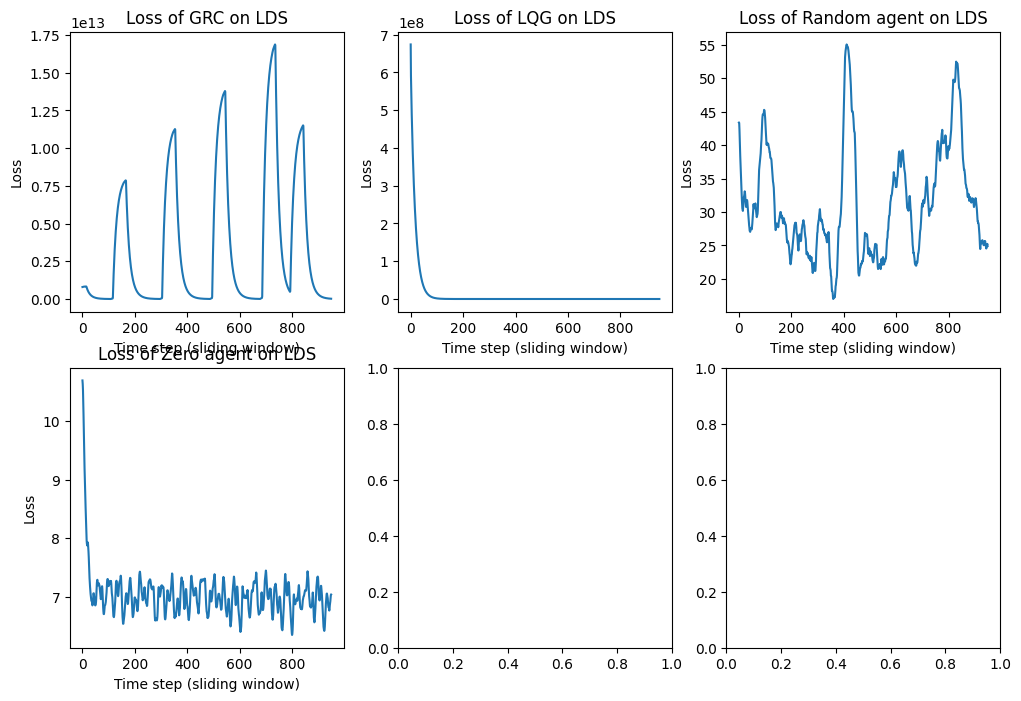

In [ ]:
# prompt: I want the same cell as above, but plot the figures side by side
%load_ext autoreload
%autoreload 2


def plot_lds_with_a_given_agent(env, agent, name_of_agent, traj_length=1000, window_size=50, ax=None ):
    obs = np.zeros(shape=(d_obs, 1))
    action = agent(obs)
    losses = np.zeros(traj_length)
    window_losses = np.zeros(traj_length - window_size)

    for i in range(traj_length):
        obs = env(action)
        action = agent(obs)
        losses[i] = np.linalg.norm(obs) + np.linalg.norm(action) # simple quadratic loss
        agent.update(obs, action)
        if i >= window_size - 1:
            window_losses[i - window_size] = np.mean(losses[i - window_size + 1: i + 1])

    if ax is None:
        _, ax = plt.subplots(figsize=(12, 8))

    ax.plot(window_losses)
    ax.set_xlabel('Time step (sliding window)')
    ax.set_ylabel('Loss')
    ax.set_title(f"Loss of {name_of_agent} on LDS")


env = LDS()  # LDS with random initiations and dimensions as specified
d_obs = 2
d_action = 3
d_hidden = 10
disturbance = SinusDisturbance()
disturbance.init(d_hidden, 0.5)
obs = env.init(d_action,d_hidden, d_obs, disturbance = disturbance)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()


agent = GRC(env.A, env.B, env.C)
agent.init()
plot_lds_with_a_given_agent(env, agent, "GRC", ax=axes[0])

agent = LQG(env.A, env.B, env.C)
agent.init()
plot_lds_with_a_given_agent(env, agent, "LQG", ax=axes[1])

agent = SimpleRandom(d_action)
agent.init()
plot_lds_with_a_given_agent(env, agent, "Random agent", ax=axes[2])

agent = Zero(d_action)
agent.init(d_action)
plot_lds_with_a_given_agent(env, agent, "Zero agent", ax=axes[3])

agent = SFC(env.A, env.B, env.C)
agent.init()
plot_lds_with_a_given_agent(env, agent, "SFC", ax=axes[4])

agent = DRC(env.A, env.B, env.C)
agent.init()
plot_lds_with_a_given_agent(env, agent, "DRC", ax=axes[5])


plt.tight_layout()
plt.show()

/Users/rsalik/.pyenv/versions/3.13.1/envs/deluca-env/lib/python3.13/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


✅ Zero agent completed! (150/150) 100%██████| 100.0% (150/150) bs from frame 145: [0.099, -0.982, 0.585...]]


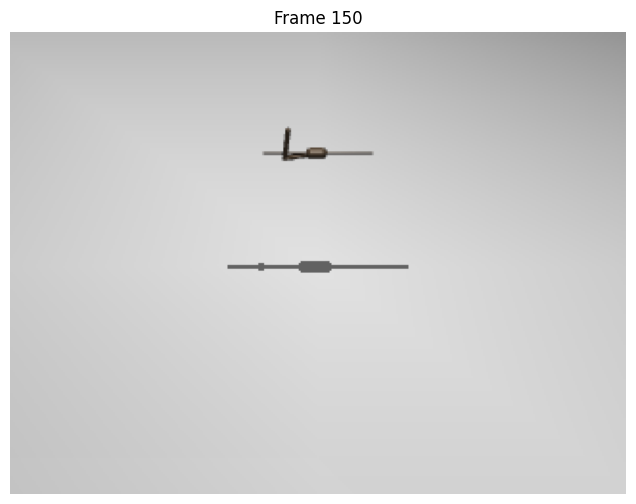

In [40]:
%load_ext autoreload
%autoreload 2

from deluca.utils.printing import Task


def test_brax_lib_env_with_agent(env, agent, name_of_agent, frames = 100, window_size=50, ax=None ):
    state = env.reset(jax.random.PRNGKey(0))

    states: Sequence = [state.pipeline_state]
    
    
    for i in range(frames):
        # Update progress bar
        print_progress(i, frames, name_of_agent)
        
        action = agent(state.obs)
        state = env.step(state, action[0])
        states.append(state.pipeline_state)
    
    # Clear the progress bar and print completion
    print_progress(frames, frames, name_of_agent)
    
    rendered_frames = env.render(states)
    
    # Display as animation
    fig, ax = plt.subplots(figsize=(8, 6))
    
    def animate(frame):
        ax.clear()
        ax.imshow(rendered_frames[frame])
        ax.set_title(f'Frame {frame}')
        ax.axis('off')
    
    anim = animation.FuncAnimation(fig, animate, frames=len(rendered_frames), 
                                 interval=50, repeat=True)
    
    # Display in notebook
    return HTML(anim.to_jshtml())

def run_with_realtime_rendering(env, agent, name_of_agent, steps=100):
    """Run environment with real-time rendering"""
    state = env.reset(jax.random.PRNGKey(0))
    
    # Create a single figure and axis for updating
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(f'{name_of_agent} Step 0')
    ax.axis('off')
    
    # Display the initial figure
    display_id = display(fig, display_id=True)
    
    for step in range(steps):
        action = agent(state.obs)
        state = env.step(state, action[0])
        
        # Render every few steps
        if step % 2 == 0:
            rendered = env.render([state.pipeline_state])
            
            # Clear the previous image and update with new one
            ax.clear()
            ax.imshow(rendered[0])
            ax.set_title(f'{name_of_agent} Step {step}')
            ax.axis('off')
            
            # Update the display in the notebook
            if display_id is not None:
                display_id.update(fig)
    
    plt.close(fig)  # Clean up the figure when done

env = InvertedDoublePendulum()
agent = SimpleRandom(env.action_size)
agent.init()
test_brax_lib_env_with_agent(env, agent, "Zero agent", frames=150)



  




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env BRAX
env <deluca.envs.brax._pendulum2d.Pendulum2D object at 0x56077aa50>
BraxEnv(env=<deluca.envs.brax._pendulum2d.Pendulum2D object at 0x56077aa50>, states=None)
⠋ Random agent |░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░| 0.8% (1/120) obs from frame 0: [[-0.00985396  0.9999514   0.01295636]]

/Users/rsalik/.pyenv/versions/3.13.1/envs/deluca-env/lib/python3.13/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


✅ Random agent completed! (120/120) 100%██████| 100.0% (120/120) bs from frame 115: [[-0.00191366  0.99999815 -0.04695075]]02]]1]]


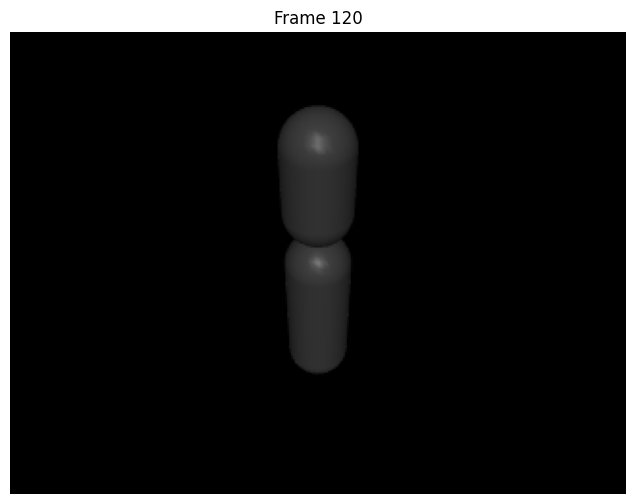

In [41]:
%load_ext autoreload
%autoreload 2

from deluca.envs import Pendulum2D

def test_deluca_brax_env_with_agent(env, agent, name_of_agent, frames = 100, window_size=50, ax=None ):
    state, obs= env.reset(jax.random.PRNGKey(0))
    
    for i in range(frames):
        # Update progress bar
        print_progress(i, frames, name_of_agent)
        
        action = agent(obs)
        state, obs = env(state, action[0])
    
    # Clear the progress bar and print completion
    print_progress(frames, frames, name_of_agent)
    
    rendered_frames = env.render()
    
    # Display as animation
    fig, ax = plt.subplots(figsize=(8, 6))
    
    def animate(frame):
        ax.clear()
        ax.imshow(rendered_frames[frame])
        ax.set_title(f'Frame {frame}')
        ax.axis('off')
    
    anim = animation.FuncAnimation(fig, animate, frames=len(rendered_frames), 
                                 interval=50, repeat=True)
    
    # Display in notebook
    return HTML(anim.to_jshtml())


env = Pendulum2D.create()
print(env)

agent = SimpleRandom(env.action_size)
agent.init()
test_deluca_brax_env_with_agent(env, agent, "Random agent", frames=120)

        ↳ ⠋ Generating trajectories [░░░░░░░░░░] [0/2]

ERROR:2025-07-08 15:12:16,685:jax._src.debugging:98: jax.debug.callback failed
Traceback (most recent call last):
  File "/Users/rsalik/.pyenv/versions/3.13.1/envs/deluca-env/lib/python3.13/site-packages/jax/_src/debugging.py", line 96, in debug_callback_impl
    callback(*args)
    ~~~~~~~~^^^^^^^
  File "/Users/rsalik/.pyenv/versions/3.13.1/envs/deluca-env/lib/python3.13/site-packages/jax/_src/debugging.py", line 336, in _flat_callback
    callback(*args, **kwargs)
    ~~~~~~~~^^^^^^^^^^^^^^^^^
  File "/Users/rsalik/Documents/Code/Google/deluca/colabs/deluca/learners/core.py", line 24, in <lambda>
    jax.debug.callback(lambda x: task.update(), trajectory_index)
                                 ~~~~~~~~~~~^^
  File "<string>", line 4, in update
AttributeError: 'Task' object has no attribute '_lock'
ERROR:jax._src.debugging:jax.debug.callback failed
Traceback (most recent call last):
  File "/Users/rsalik/.pyenv/versions/3.13.1/envs/deluca-env/lib/python3.13/site-packages/jax/_src/deb

AttributeError: 'Task' object has no attribute '_lock'

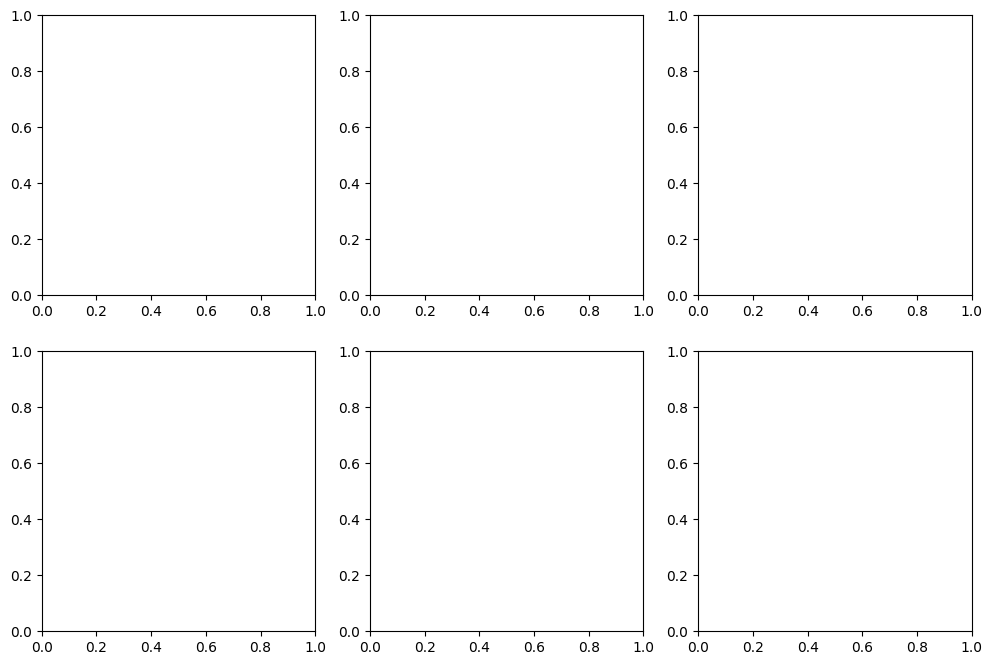

In [10]:
%autoreload 2

# Learned Environments

from deluca.learners import NNLearner
from deluca.envs import Pendulum2D
import jax
import jax.numpy as jnp
from deluca.agents import SimpleRandom
import matplotlib.pyplot as plt

from deluca.utils.printing import Task

# Test the NNLearner

def compare_learned_env_with_true_env(env, learner, name, axes, num_epochs=100):
    lenv = learner.get_learned_env()

    t_state, t_obs = env.init(jax.random.PRNGKey(0))
    t_obs = lenv.init()

    agent = SimpleRandom(env.action_size)
    agent.init()

    diffs = []

    task = Task("Comparing learned and true environments", num_epochs)
    for i in range(num_epochs):
        action = agent(t_obs)
        l_obs = lenv(t_obs, action[0])
        t_state, t_obs = env(t_state, action[0])

        diff = jnp.mean(l_obs - t_obs)
        diffs.append(diff)
        task.update()

    task.complete()

    # Plot as histogram
    axes.hist(diffs, bins=20)
    # Add a vertical line at 0
    axes.axvline(x=0, color='red', linestyle='--')

    # consistent range for x axis
    axes.set_xlim(-0.15, 0.15)

    axes.set_title(f"Loss distribution for {name} trained model")
    axes.set_xlabel("Loss")
    axes.set_ylabel("Frequency")

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

env = Pendulum2D().create()

learner = NNLearner(env)
trajectories = learner.generate_trajectories(2, 2)
learn_losses = learner.learn(trajectories, num_epochs=100)

# Plot losses for 10x10 trajectories

axes[0].plot(learn_losses)
axes[0].set_title("Losses for 2x2 trajectories")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

compare_learned_env_with_true_env(env, learner, "2x2", axes[3])

learner = NNLearner(env)
trajectories = learner.generate_trajectories(100, 100)
learn_losses = learner.learn(trajectories, num_epochs=100)

axes[1].plot(learn_losses)
axes[1].set_title("Losses for 100x100 trajectories")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")

compare_learned_env_with_true_env(env, learner, "100x100", axes[4])

learner = NNLearner(env)
trajectories = learner.generate_trajectories(250, 250)
learn_losses = learner.learn(trajectories, num_epochs=100)

axes[2].plot(learn_losses)
axes[2].set_title("Losses for 250x250 trajectories")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss")

compare_learned_env_with_true_env(env, learner, "250x250", axes[5])

plt.show()
